Epoch 1:   0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Epoch 1: 100%|██████████| 572/572 [03:57<00:00,  2.41it/s]


Epoch 1 - Loss: 1.0801, Val Acc: 0.6224


Epoch 2: 100%|██████████| 572/572 [02:05<00:00,  4.57it/s]


Epoch 2 - Loss: 0.7346, Val Acc: 0.7360


Epoch 3: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 3 - Loss: 0.5571, Val Acc: 0.7876


Epoch 4: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 4 - Loss: 0.4603, Val Acc: 0.8217


Epoch 5: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 5 - Loss: 0.3904, Val Acc: 0.8269


Epoch 6: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 6 - Loss: 0.3368, Val Acc: 0.8531


Epoch 7: 100%|██████████| 572/572 [02:09<00:00,  4.41it/s]


Epoch 7 - Loss: 0.2919, Val Acc: 0.8733


Epoch 8: 100%|██████████| 572/572 [02:06<00:00,  4.54it/s]


Epoch 8 - Loss: 0.2582, Val Acc: 0.8802


Epoch 9: 100%|██████████| 572/572 [02:05<00:00,  4.56it/s]


Epoch 9 - Loss: 0.2337, Val Acc: 0.8890


Epoch 10: 100%|██████████| 572/572 [02:04<00:00,  4.60it/s]


Epoch 10 - Loss: 0.2063, Val Acc: 0.8899
Model saved to cfcc_cnn_model.pt

Classification Report:
              precision    recall  f1-score   support

    VERY LOW       0.91      0.96      0.94       382
         LOW       0.92      0.86      0.89       228
      MEDIUM       0.95      0.82      0.88       230
        HIGH       0.86      0.93      0.89       304

    accuracy                           0.90      1144
   macro avg       0.91      0.89      0.90      1144
weighted avg       0.91      0.90      0.90      1144

F1 Score: 0.9040484987846401
Jaccard Index: 0.8257495729789938
MCC: 0.8712937224544266
Hamming Loss: 0.09527972027972027


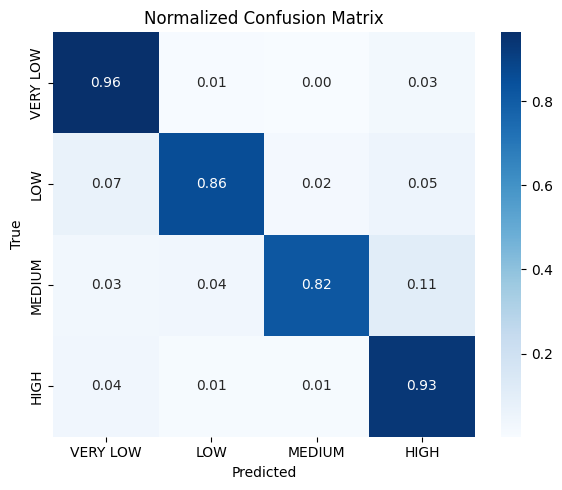

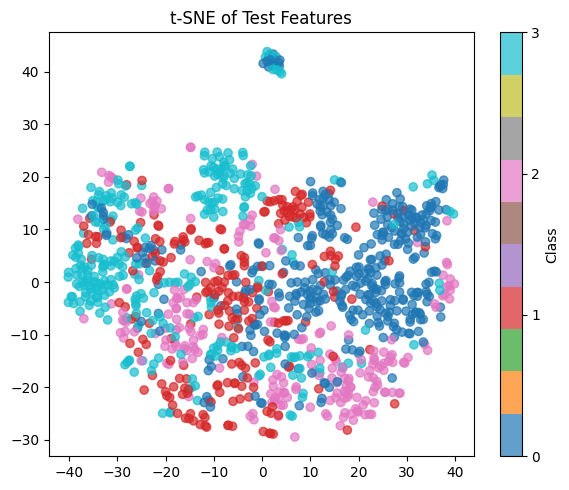

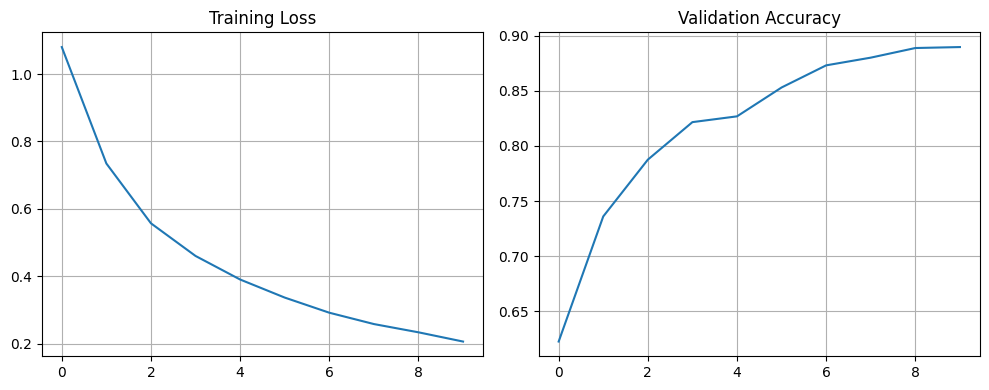

In [1]:
import os
import torch
import torch.nn as nn
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, matthews_corrcoef, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tqdm import tqdm

# ========== CONFIG ==========
DATASET_DIR = "/kaggle/input/class-data/class-data"  # Change path if needed
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABEL_MAP = {'VERY LOW': 0, 'LOW': 1, 'MEDIUM': 2, 'HIGH': 3}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# ========== CFCC Feature Extraction ==========
def extract_cfcc_features(audio_path, sr=16000, n_mfcc=14):
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != sr:
        resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
        waveform = resample(waveform)

    waveform = waveform.mean(dim=0, keepdim=True)  # Mono
    mfcc = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=n_mfcc)(waveform)
    delta = torchaudio.functional.compute_deltas(mfcc)
    delta2 = torchaudio.functional.compute_deltas(delta)
    cfcc = torch.cat([mfcc, delta, delta2], dim=1)  # (1, 3*n_mfcc, time)
    
    # Normalize
    cfcc = (cfcc - cfcc.mean()) / (cfcc.std() + 1e-5)
    
    return cfcc.squeeze(0).transpose(0, 1)  # (time, features)

# ========== Dataset ==========
class CFCCDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []

        for label in os.listdir(root_dir):
            class_path = os.path.join(root_dir, label)
            if not os.path.isdir(class_path): continue
            for file in os.listdir(class_path):
                if file.endswith(".wav"):
                    self.samples.append(os.path.join(class_path, file))
                    self.labels.append(LABEL_MAP[label])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        feature = extract_cfcc_features(self.samples[idx])
        feature = feature.T  # (features, time)
        feature = feature.unsqueeze(0).unsqueeze(0)  # (1, 1, features, time)
        feature = torch.nn.functional.interpolate(feature, size=(64, 42), mode='bilinear')
        feature = feature.squeeze(0)  # (1, 64, 42)
        return feature.squeeze(0), self.labels[idx]

# ========== CNN Model ==========
class CFCC_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CFCC_CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

# ========== Train & Evaluate ==========
def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_losses, val_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            X, y = X.unsqueeze(1).to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.unsqueeze(1).to(DEVICE), y.to(DEVICE)
                outputs = model(X)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_accuracies.append(correct / total)
        print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_accuracies

# ========== Main ==========
if __name__ == "__main__":
    dataset = CFCCDataset(DATASET_DIR)

    total_idx = np.arange(len(dataset))
    train_idx, temp_idx = train_test_split(total_idx, test_size=0.2, stratify=dataset.labels, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=np.array(dataset.labels)[temp_idx], random_state=42)

    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)
    test_set = torch.utils.data.Subset(dataset, test_idx)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    model = CFCC_CNN(num_classes=NUM_CLASSES).to(DEVICE)
    train_losses, val_accuracies = train_model(model, train_loader, val_loader)

    # Save model
    model_path = "cfcc_cnn_model.pt"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # ========== Evaluation ==========
    model.eval()
    y_true, y_pred = [], []
    features_all = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.unsqueeze(1).to(DEVICE)
            y_true.extend(y.numpy())

            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())

            # Collect features for t-SNE
            feats = model.conv(X).view(X.size(0), -1).cpu()
            features_all.append(feats)

    features_all = torch.cat(features_all)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=LABEL_MAP.keys()))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Jaccard Index:", jaccard_score(y_true, y_pred, average='weighted'))
    print("MCC:", matthews_corrcoef(y_true, y_pred))
    print("Hamming Loss:", hamming_loss(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=True, cmap='Blues',
                xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys(), fmt='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    features_tsne = tsne.fit_transform(features_all)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y_true, cmap='tab10', alpha=0.7)
    plt.title("t-SNE of Test Features")
    plt.colorbar(scatter, ticks=range(4), label="Class")
    plt.tight_layout()
    plt.show()

    # Loss / Accuracy plots
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title("Validation Accuracy")
    plt.grid()
    plt.tight_layout()
    plt.savefig("cfcc_training_plots.png")


Epoch 1:   0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Epoch 1: 100%|██████████| 572/572 [02:12<00:00,  4.31it/s]


Epoch 1 - Loss: 0.1959, Val Acc: 0.8951


Epoch 2: 100%|██████████| 572/572 [02:05<00:00,  4.58it/s]


Epoch 2 - Loss: 0.1701, Val Acc: 0.8837


Epoch 3: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 3 - Loss: 0.1535, Val Acc: 0.9073


Epoch 4: 100%|██████████| 572/572 [02:03<00:00,  4.62it/s]


Epoch 4 - Loss: 0.1462, Val Acc: 0.9082


Epoch 5: 100%|██████████| 572/572 [02:04<00:00,  4.60it/s]


Epoch 5 - Loss: 0.1304, Val Acc: 0.9082


Epoch 6: 100%|██████████| 572/572 [02:04<00:00,  4.61it/s]


Epoch 6 - Loss: 0.1199, Val Acc: 0.9117


Epoch 7: 100%|██████████| 572/572 [02:04<00:00,  4.59it/s]


Epoch 7 - Loss: 0.1124, Val Acc: 0.9065


Epoch 8: 100%|██████████| 572/572 [02:02<00:00,  4.65it/s]


Epoch 8 - Loss: 0.0984, Val Acc: 0.9196


Epoch 9: 100%|██████████| 572/572 [02:03<00:00,  4.64it/s]


Epoch 9 - Loss: 0.0913, Val Acc: 0.9135


Epoch 10: 100%|██████████| 572/572 [02:03<00:00,  4.62it/s]


Epoch 10 - Loss: 0.0840, Val Acc: 0.9266
Model saved to cfcc_cnn_model_extended.pt

Classification Report:
              precision    recall  f1-score   support

    VERY LOW       0.95      0.98      0.96       382
         LOW       0.96      0.90      0.93       228
      MEDIUM       0.94      0.89      0.92       230
        HIGH       0.93      0.96      0.94       304

    accuracy                           0.94      1144
   macro avg       0.94      0.93      0.94      1144
weighted avg       0.94      0.94      0.94      1144

F1 Score: 0.941957282898968
Jaccard Index: 0.890848748053181
MCC: 0.9218649230038951
Hamming Loss: 0.057692307692307696


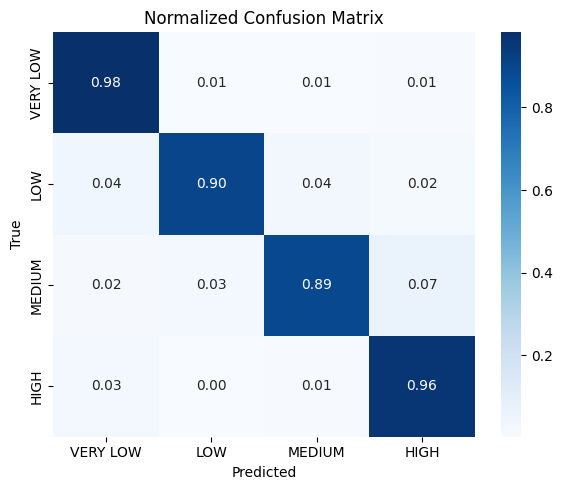

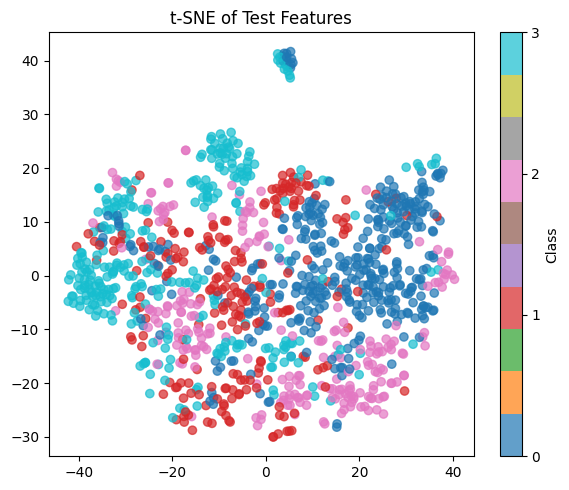

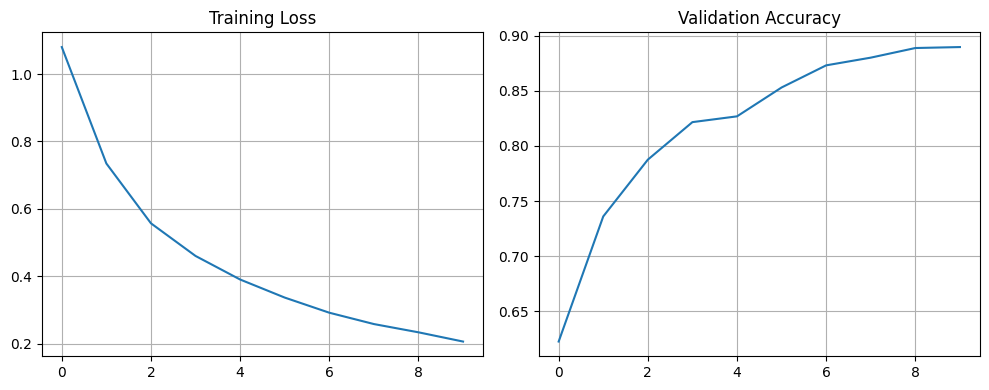

In [2]:
train_losses_extended, val_accuracies_extended = train_model(model, train_loader, val_loader)

# Save model
model_path = "cfcc_cnn_model_extended.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# ========== Evaluation ==========
model.eval()
y_true, y_pred = [], []
features_all = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.unsqueeze(1).to(DEVICE)
        y_true.extend(y.numpy())

        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())

        # Collect features for t-SNE
        feats = model.conv(X).view(X.size(0), -1).cpu()
        features_all.append(feats)

features_all = torch.cat(features_all)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=LABEL_MAP.keys()))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Jaccard Index:", jaccard_score(y_true, y_pred, average='weighted'))
print("MCC:", matthews_corrcoef(y_true, y_pred))
print("Hamming Loss:", hamming_loss(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=True, cmap='Blues',
            xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys(), fmt='.2f')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_all)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y_true, cmap='tab10', alpha=0.7)
plt.title("t-SNE of Test Features")
plt.colorbar(scatter, ticks=range(4), label="Class")
plt.tight_layout()
plt.show()

# Loss / Accuracy plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.grid()
plt.tight_layout()
plt.savefig("cfcc_training_plots.png")